<center><img src="https://pbs.twimg.com/media/FommiJ9WIAEBPI0.jpg" width="500" /></center>
    
 <center> 

# Fase Nacional
## Prediccion - Equipo **Malbecs**

</center>

**Integrantes**

- Denis Trosman
- Vito Stamatti
- Sumit Kumar Jethani Jethani

# Contenido

El presente notebook se estructura de la siguiente manera

1. Preproceso UH_2023_TRAIN.txt 
2. Ingenieria de Variables de UH_2023_TRAIN.txt
3. Preproceso DATOS_ETO.txt
4. Ingenieria de Variablesde DATOS_ETO.txt
5. Ingenieria de Variables de DATOS_METEO.txt
6. Entrenamiento y Validacion
7. Prediccion Final

## Transparencia

Memoria del modelo

- Instrucciones de uso 
- Tratamientos sobre los datasets de datos 
- Elección de la muestra de entrenamiento y validación 
- Argumento de la tipología del modelo a desarrollar 
- Criterios aplicados para la selección del ganador 
- Visualización y explicación de los resultados


Consideramos que todos estos puntos fueron tratados correctamente en el script de Predicción. En este, comentamos claramente los pasos seguidos y motivos por los cuales fuimos generando determinadas funciones o dejando de lado variables.

A la hora de seleccionar el modelo ganador, no solo hemos evaluado el puntaje para nuestro set de evaluación, sino tambien que tan bien le fue a este en los años pasados. Tambien tuvimos en cuenta la interpretación del modelo y los tiempos de ejecución de estos, logrando un alto nivel de transparencia.

Esto se plasmó luego en la memoria adjuntada en la entrega final, donde se explica el funcionamiento del modelo y se favorece así el entendimiento por parte del usuario final.

# MENCIONAR SI HACEMOS UN DASHBOARD ACA

# 1. Preproceso UH_2023_TRAIN.txt

In [18]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)  


from malbecs.preprocess import wine as wine_pr
from malbecs.feateng import wine as wine_fe

seed = 42
raw_wine_path = "../data/raw/UH_2023_TRAIN.txt"
pro_wine_path = "../data/processed/wine_pro.csv" 
final_wine_path = "../data/final/wine_final.csv" 

Carga de datos

In [19]:
wine_data = wine_pr.load_wine_dataset(raw_wine_path)
wine_data.sample(5, random_state=seed)

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION
1318,15,68089,506,16,600-620,26,2,0,1,0.00,5799.42
9504,22,91845,47,19,520-540,38,2,0,0,0.69,NaN
7222,20,95959,299,12,440-450,17,1,0,1,0.55,1040.00
5391,18,53298,473,10,450-480,9,1,0,0,0.00,740.00
9166,22,2913,449,3,550-700,52,2,0,1,1.33,NaN


Conversion de altitud en formato texto a formato numerico. Se utiliza el promedio de altitudes en el caso de haber 2 valores presentes

Reemplazamos valores en 0 por nulos para ser imputados posteriormente

Imputacion de altitud promedio por estacion

Imputacion jerarquica de superficie por agrupada por diferentes niveles de agregacion.

In [20]:
wine_data = wine_pr.preproces_wine_data(wine_data)
wine_data.sample(5, random_state=seed)

,campaña,id_finca,id_zona,id_estacion,altitud,variedad,modo,tipo,color,superficie,produccion,std_superficie,std_superficie_null,sup_is_nan
1318,15,68089,506,16,610.00,26,2,0,1,2.40,5799.42,0.00,True,1.00
9504,22,91845,47,19,530.00,38,2,0,0,0.69,NaN,0.00,True,0.00
7222,20,95959,299,12,445.00,17,1,0,1,0.55,1040.00,0.00,True,0.00
5391,18,53298,473,10,465.00,9,1,0,0,0.70,740.00,NaN,False,1.00
9166,22,2913,449,3,625.00,52,2,0,1,1.33,NaN,0.45,False,0.00


### Diccionario de Variables

- std_superficie_null: si el desvio estandard de la superficie para la finca-variedad-modo es nulo
- std_superficie: el desvio estandar de la superficie para esta finca-variedad-modo
- sup_is_nan: si la superficie era nula y por lo tanto fue imputada
- sup_tot_camp_finca: la superficie total de esta finca para la campaña
- superficie_total: la superficie total media de la finca.
- n_var_camp_finca: cantidad de variedades diferences cultivadas en una finca
- prod_shift1: produccion de la finca en la campaña anterior
- prod_shift2: produccion de la finca dos campañas anteriores
- sup_shift1: superficie de la finca en la campaña anterior
- sup_shift2: superficie de la finca dos campañas anteriores
- prod_shift1_gt_shift2: si la produccion de la campaña anterior fue mayor a la de dos anteriores
- prod_shift_max: la maxima producion entre la campaña anterior y dos anteriores.
- prod_shift_change: cambio entre la produccion de la campaña anterior y las dos anteriores.
- prod_shift_avg: promedio de la produccion de la campaña anterior y dos anteriores.
- prod_est_mean_change: cambio en la produccion media de la estacion para la campaña anterior y dos anteriores.
- prod_he_shift1: produccion por hectarea de la campaña anterior
- prod_he_shift2: produccion por hectarea de dos campañas anteriores.
- prod_he_shift_change: cambio de produccion por hectarea entre la campaña anterior y dos anteriores.
- prod_he_shift_avg: produccion por hectarea promedio entre la campaña anterior y dos anteriores.
- prod_he_var_zone_mean_hist: promedio historico de produccion por hectarea para la variedad-modo-zona.
- prod_he_var_zone_std_hist: desvio estandard historico de produccion por hectarea para la variedad-modo-zona.
- prod_he_var_mean_hist: promedio historico de produccion por hectarea para la variedad.
- prod_he_var_std_hist: desvio estandard historico de produccion por hectarea para la variedad.
- prod_var_shift_1: produccion por hectarea de la campaña anterior.
- prod_var_shift_2: produccion por hectarea de dos campañas anteriores.
- prod_he_var_modo_zona_mean_shift1: produccion por hectarea promedio para la variedad-modo-zona.
- prod_he_var_modo_zona_std_shift1: desvio estandard de la produccion por hectarea para la variedad-modo-zona.
- prod_he_var_modo_zona_change: cambio en la produccion por hectarea de la campaña anterior y dos anteriores.
- prod_he_var_modo_mean_shift1: produccion por hectarea promedio para cada variedad y modo
- prod_he_var_modo_std_shift1: desvio estandard de la produccion por hectarea para cada variedad y modo
- prod_he_var_modo_change: 
- prod_he_var_mean_shift1: 
- prod_he_var_std_shift1: 
- prod_he_var_change: 
- prod_he_zona_mean_shift1: 
- prod_he_zona_std_shift1: 
- prod_he_zona_change: 
- prod_finca_shift_1: 
- prod_finca_shift_1: 
- prod_he_shift1_total: 
- prod_he_shift2_total: 
- prod_he_shift_change_total: 
- prod_he_shift_avg_total: 
- prod_he_var_zone_mean_hist_total: 
- prod_he_var_zone_std_hist_total: 
- prod_he_var_mean_hist_total: 
- prod_he_var_std_hist_total: 
- prod_he_var_modo_zona_mean_shift1_total: 
- prod_he_var_modo_zona_std_shift1_total: 
- prod_he_var_modo_zona_change_total: 
- prod_he_var_modo_mean_shift1_total: 
- prod_he_var_modo_std_shift1_total: 
- prod_he_var_modo_change_total: 
- prod_he_var_mean_shift1_total: 
- prod_he_var_std_shift1_total: 
- prod_he_var_change_total: 
- prod_he_zona_mean_shift1_total: 
- prod_he_zona_std_shift1_total: 
- prod_he_zona_change_tota: 

In [21]:
wine_data = wine_fe.feateng_wine_data(wine_data)
wine_data.sample(5, random_state=seed)

,campaña,id_finca,id_zona,id_estacion,altitud,variedad,modo,tipo,color,superficie,produccion,std_superficie,std_superficie_null,sup_is_nan,sup_tot_camp_finca,superficie_total,n_var_camp_finca,prod_shift1,prod_shift2,sup_shift1,sup_shift2,prod_shift1_gt_shift2,prod_shift_max,prod_shift_change,prod_shift_avg,prod_est_mean_change,prod_he_shift1,prod_he_shift2,prod_he_shift_change,prod_he_shift_avg,prod_he_var_zone_mean_hist,prod_he_var_zone_std_hist,prod_he_var_mean_hist,prod_he_var_std_hist,prod_var_shift_1,prod_var_shift_2,prod_he_var_modo_zona_mean_shift1,prod_he_var_modo_zona_std_shift1,prod_he_var_modo_zona_change,prod_he_var_modo_mean_shift1,prod_he_var_modo_std_shift1,prod_he_var_modo_change,prod_he_var_mean_shift1,prod_he_var_std_shift1,prod_he_var_change,prod_he_zona_mean_shift1,prod_he_zona_std_shift1,prod_he_zona_change,prod_finca_shift_1,prod_finca_shift_1,prod_he_shift1_total,prod_he_shift2_total,prod_he_shift_change_total,prod_he_shift_avg_total,prod_he_var_zone_mean_hist_total,prod_he_var_zone_std_hist_total,prod_he_var_mean_hist_total,prod_he_var_std_hist_total,prod_he_var_modo_zona_mean_shift1_total,prod_he_var_modo_zona_std_shift1_total,prod_he_var_modo_zona_change_total,prod_he_var_modo_mean_shift1_total,prod_he_var_modo_std_shift1_total,prod_he_var_modo_change_total,prod_he_var_mean_shift1_total,prod_he_var_std_shift1_total,prod_he_var_change_total,prod_he_zona_mean_shift1_total,prod_he_zona_std_shift1_total,prod_he_zona_change_total
1318,15,87873,272,16,635.00,59,1,0,1,5.96,15377.76,0.00,True,1.00,13.29,13.29,2,8456.80,-1.00,5.96,-1.00,1,8456.80,8457.80,8456.80,0.89,1419.81,-1.00,1420.81,1419.81,817.45,1572.02,1977.78,3850.73,16394.40,-1.00,1752.81,1935.50,1753.81,4087.89,4695.14,4025.84,4200.38,4652.38,4161.02,2314.70,2448.98,2315.70,22080.00,22080.00,8456.80,-5.96,8462.76,8456.80,4868.95,9363.45,11780.24,22936.11,10440.28,11528.42,10446.23,24348.70,27965.66,23979.10,25018.75,27710.96,24784.27,13787.04,14586.87,13792.99
9504,22,57052,233,9,440.00,17,1,0,1,1.83,-1.00,0.00,True,0.00,10.82,10.82,3,-1.00,-1.00,-1.00,-1.00,0,-1.00,0.00,-1.00,0.68,-1.00,-1.00,0.00,-1.00,-1.00,-1.00,3076.62,3996.87,-1.00,-1.00,-1.00,-1.00,0.00,3177.84,2257.29,-23.73,3430.25,2322.29,-351.39,-1.00,0.00,0.00,-1.00,-1.00,-1.83,-1.83,0.00,-1.83,-1.83,-1.83,5630.22,7314.28,-1.83,-1.83,0.00,5815.45,4130.83,-43.42,6277.35,4249.79,-643.04,-1.83,0.00,0.00
7222,20,38443,939,16,610.00,17,1,0,1,1.11,4368.00,0.00,True,0.00,1.11,1.11,1,3822.00,5526.61,1.11,1.11,0,5526.61,-1704.61,4674.31,0.54,3445.42,4982.07,-1536.65,4213.74,4774.35,3035.77,3058.48,4201.26,3822.00,5526.61,5463.60,1892.98,594.65,3313.54,2041.14,-396.48,3992.98,2414.55,-268.13,4713.40,2442.53,-11.15,3822.00,3822.00,3822.00,5526.61,-1704.61,4674.30,5296.19,3367.58,3392.78,4660.45,6060.78,2099.88,659.65,3675.71,2264.24,-439.81,4429.42,2678.47,-297.44,5228.57,2709.50,-12.36
5391,18,94589,401,10,525.00,59,2,0,1,0.21,1066.82,0.00,True,1.00,0.21,0.61,1,-1.00,-1.00,-1.00,-1.00,0,-1.00,0.00,-1.00,0.42,-1.00,-1.00,0.00,-1.00,-1.00,0.00,4203.25,4025.39,-1.00,-1.00,-1.00,0.00,0.00,3948.82,2709.28,-1316.82,3033.67,2268.50,-1526.90,-1.00,0.00,0.00,-1.00,-1.00,-0.21,-0.21,0.00,-0.21,-0.21,0.00,896.55,858.61,-0.21,0.00,0.00,842.28,577.89,-280.88,647.08,483.87,-325.69,-0.21,0.00,0.00
9166,22,84380,441,12,462.50,17,1,0,1,0.12,-1.00,0.00,True,0.00,0.12,0.12,1,285.58,293.44,0.12,0.12,0,293.44,-7.86,289.51,0.41,2414.03,2480.47,-66.44,2447.25,2472.05,2780.54,3076.62,3996.87,285.58,293.44,2460.95,1880.17,-1415.93,3177.84,2257.29,-23.73,3430.25,2322.29,-351.39,3981.74,2636.92,-1909.53,285.58,285.58,285.58,293.44,-7.86,289.51,292.44,328.94,363.96,472.83,291.13,222.42,-167.50,375.94,267.04,-2.81,405.80,274.73,-41.57,471.04,311.95,-225.90


# 2. Preproceso DATOS_ETO.txt

In [27]:
from malbecs.preprocess import eto as eto_pr
from malbecs.feateng import eto as eto_fe

raw_eto_path = '../data/raw/DATOS_ETO.TXT'

In [28]:
eto_data = eto_pr.load_eto_dataset(raw_eto_path)

In [29]:
eto_data = eto_pr.preprocess_eto_dataset(
    eto_data,
    cols_mean=eto_pr.cols_mean,
    cols_sum=eto_pr.cols_sum
)
eto_data.head()

,year,ID_ESTACION,MeanDewpointLocalDayAvgMonth1,MeanDewpointLocalDayAvgMonth2,MeanDewpointLocalDayAvgMonth3,MeanDewpointLocalDayAvgMonth4,MeanDewpointLocalDayAvgMonth5,MeanDewpointLocalDayAvgMonth6,MeanEvapotranspirationLocalDayAvgMonth1,MeanEvapotranspirationLocalDayAvgMonth2,MeanEvapotranspirationLocalDayAvgMonth3,MeanEvapotranspirationLocalDayAvgMonth4,MeanEvapotranspirationLocalDayAvgMonth5,MeanEvapotranspirationLocalDayAvgMonth6,MeanFeelsLikeLocalDayAvgMonth1,MeanFeelsLikeLocalDayAvgMonth2,MeanFeelsLikeLocalDayAvgMonth3,MeanFeelsLikeLocalDayAvgMonth4,MeanFeelsLikeLocalDayAvgMonth5,MeanFeelsLikeLocalDayAvgMonth6,MeanGlobalHorizontalIrradianceLocalDayAvgMonth1,MeanGlobalHorizontalIrradianceLocalDayAvgMonth2,MeanGlobalHorizontalIrradianceLocalDayAvgMonth3,MeanGlobalHorizontalIrradianceLocalDayAvgMonth4,MeanGlobalHorizontalIrradianceLocalDayAvgMonth5,MeanGlobalHorizontalIrradianceLocalDayAvgMonth6,MeanGustLocalDayAvgMonth1,MeanGustLocalDayAvgMonth2,MeanGustLocalDayAvgMonth3,MeanGustLocalDayAvgMonth4,MeanGustLocalDayAvgMonth5,MeanGustLocalDayAvgMonth6,MeanMSLPLocalDayAvgMonth1,MeanMSLPLocalDayAvgMonth2,MeanMSLPLocalDayAvgMonth3,MeanMSLPLocalDayAvgMonth4,MeanMSLPLocalDayAvgMonth5,MeanMSLPLocalDayAvgMonth6,MeanPrecipAmountLocalDayAvgMonth1,MeanPrecipAmountLocalDayAvgMonth2,MeanPrecipAmountLocalDayAvgMonth3,MeanPrecipAmountLocalDayAvgMonth4,MeanPrecipAmountLocalDayAvgMonth5,MeanPrecipAmountLocalDayAvgMonth6,MeanRelativeHumidityLocalDayAvgMonth1,MeanRelativeHumidityLocalDayAvgMonth2,MeanRelativeHumidityLocalDayAvgMonth3,MeanRelativeHumidityLocalDayAvgMonth4,MeanRelativeHumidityLocalDayAvgMonth5,MeanRelativeHumidityLocalDayAvgMonth6,MeanSnowAmountLocalDayAvgMonth1,MeanSnowAmountLocalDayAvgMonth2,MeanSnowAmountLocalDayAvgMonth3,MeanSnowAmountLocalDayAvgMonth4,MeanSnowAmountLocalDayAvgMonth5,MeanSnowAmountLocalDayAvgMonth6,MeanTemperatureLocalDayAvgMonth1,MeanTemperatureLocalDayAvgMonth2,MeanTemperatureLocalDayAvgMonth3,MeanTemperatureLocalDayAvgMonth4,MeanTemperatureLocalDayAvgMonth5,MeanTemperatureLocalDayAvgMonth6,MeanUVIndexLocalDayAvgMonth1,MeanUVIndexLocalDayAvgMonth2,MeanUVIndexLocalDayAvgMonth3,MeanUVIndexLocalDayAvgMonth4,MeanUVIndexLocalDayAvgMonth5,MeanUVIndexLocalDayAvgMonth6,MeanVisibilityLocalDayAvgMonth1,MeanVisibilityLocalDayAvgMonth2,MeanVisibilityLocalDayAvgMonth3,MeanVisibilityLocalDayAvgMonth4,MeanVisibilityLocalDayAvgMonth5,MeanVisibilityLocalDayAvgMonth6,MeanWindSpeedLocalDayAvgMonth1,MeanWindSpeedLocalDayAvgMonth2,MeanWindSpeedLocalDayAvgMonth3,MeanWindSpeedLocalDayAvgMonth4,MeanWindSpeedLocalDayAvgMonth5,MeanWindSpeedLocalDayAvgMonth6,MeanDewpointLocalDayMaxMonth1,MeanDewpointLocalDayMaxMonth2,MeanDewpointLocalDayMaxMonth3,MeanDewpointLocalDayMaxMonth4,MeanDewpointLocalDayMaxMonth5,MeanDewpointLocalDayMaxMonth6,MeanEvapotranspirationLocalDayMaxMonth1,MeanEvapotranspirationLocalDayMaxMonth2,MeanEvapotranspirationLocalDayMaxMonth3,MeanEvapotranspirationLocalDayMaxMonth4,MeanEvapotranspirationLocalDayMaxMonth5,MeanEvapotranspirationLocalDayMaxMonth6,MeanFeelsLikeLocalDayMaxMonth1,MeanFeelsLikeLocalDayMaxMonth2,MeanFeelsLikeLocalDayMaxMonth3,MeanFeelsLikeLocalDayMaxMonth4,MeanFeelsLikeLocalDayMaxMonth5,MeanFeelsLikeLocalDayMaxMonth6,MeanGlobalHorizontalIrradianceLocalDayMaxMonth1,MeanGlobalHorizontalIrradianceLocalDayMaxMonth2,MeanGlobalHorizontalIrradianceLocalDayMaxMonth3,MeanGlobalHorizontalIrradianceLocalDayMaxMonth4,MeanGlobalHorizontalIrradianceLocalDayMaxMonth5,MeanGlobalHorizontalIrradianceLocalDayMaxMonth6,MeanGustLocalDayMaxMonth1,MeanGustLocalDayMaxMonth2,MeanGustLocalDayMaxMonth3,MeanGustLocalDayMaxMonth4,MeanGustLocalDayMaxMonth5,MeanGustLocalDayMaxMonth6,MeanMSLPLocalDayMaxMonth1,MeanMSLPLocalDayMaxMonth2,MeanMSLPLocalDayMaxMonth3,MeanMSLPLocalDayMaxMonth4,MeanMSLPLocalDayMaxMonth5,MeanMSLPLocalDayMaxMonth6,MeanPrecipAmountLocalDayMaxMonth1,MeanPrecipAmountLocalDayMaxMonth2,MeanPrecipAmountLocalDayMaxMonth3,MeanPrecipAmountLocalDayMaxMonth4,MeanPrecipAmountLocalDayMaxMonth5,MeanPrecipAmountLocalDayMa

Seleccionamos las columnas que nos interesa utilizar como potenciales features.

Creamos las columnas de *year* y *month* para pode pivotear el los datos y combinarlos con nuestro dataset de entrenamiento.

Realizamos un pivot sobre los datos

Seleccionamos los meses relevantes para el problema. Dichos meses se corresponden con el periodo de crecimiento de la vid.

Imputamos valores nulos con 0 para variables asociadas a Gust, Snow y Precipitation

Imputamos datos faltantes a partir de promedios mensuales por estacion.

Pivoteamos data para obtener un registro por estacion y mes

Imputamos datos faltantes con promedios por estacion

Generamos nuevas variables acumulando los meses.

In [30]:
eto_data = eto_fe.feateng_eto(eto_data)
eto_data.head()

,year,ID_ESTACION,MeanDewpointLocalDayAvgMonth1,MeanDewpointLocalDayAvgMonth2,MeanDewpointLocalDayAvgMonth3,MeanDewpointLocalDayAvgMonth4,MeanDewpointLocalDayAvgMonth5,MeanDewpointLocalDayAvgMonth6,MeanEvapotranspirationLocalDayAvgMonth1,MeanEvapotranspirationLocalDayAvgMonth2,MeanEvapotranspirationLocalDayAvgMonth3,MeanEvapotranspirationLocalDayAvgMonth4,MeanEvapotranspirationLocalDayAvgMonth5,MeanEvapotranspirationLocalDayAvgMonth6,MeanFeelsLikeLocalDayAvgMonth1,MeanFeelsLikeLocalDayAvgMonth2,MeanFeelsLikeLocalDayAvgMonth3,MeanFeelsLikeLocalDayAvgMonth4,MeanFeelsLikeLocalDayAvgMonth5,MeanFeelsLikeLocalDayAvgMonth6,MeanGlobalHorizontalIrradianceLocalDayAvgMonth1,MeanGlobalHorizontalIrradianceLocalDayAvgMonth2,MeanGlobalHorizontalIrradianceLocalDayAvgMonth3,MeanGlobalHorizontalIrradianceLocalDayAvgMonth4,MeanGlobalHorizontalIrradianceLocalDayAvgMonth5,MeanGlobalHorizontalIrradianceLocalDayAvgMonth6,MeanGustLocalDayAvgMonth1,MeanGustLocalDayAvgMonth2,MeanGustLocalDayAvgMonth3,MeanGustLocalDayAvgMonth4,MeanGustLocalDayAvgMonth5,MeanGustLocalDayAvgMonth6,MeanMSLPLocalDayAvgMonth1,MeanMSLPLocalDayAvgMonth2,MeanMSLPLocalDayAvgMonth3,MeanMSLPLocalDayAvgMonth4,MeanMSLPLocalDayAvgMonth5,MeanMSLPLocalDayAvgMonth6,MeanPrecipAmountLocalDayAvgMonth1,MeanPrecipAmountLocalDayAvgMonth2,MeanPrecipAmountLocalDayAvgMonth3,MeanPrecipAmountLocalDayAvgMonth4,MeanPrecipAmountLocalDayAvgMonth5,MeanPrecipAmountLocalDayAvgMonth6,MeanRelativeHumidityLocalDayAvgMonth1,MeanRelativeHumidityLocalDayAvgMonth2,MeanRelativeHumidityLocalDayAvgMonth3,MeanRelativeHumidityLocalDayAvgMonth4,MeanRelativeHumidityLocalDayAvgMonth5,MeanRelativeHumidityLocalDayAvgMonth6,MeanSnowAmountLocalDayAvgMonth1,MeanSnowAmountLocalDayAvgMonth2,MeanSnowAmountLocalDayAvgMonth3,MeanSnowAmountLocalDayAvgMonth4,MeanSnowAmountLocalDayAvgMonth5,MeanSnowAmountLocalDayAvgMonth6,MeanTemperatureLocalDayAvgMonth1,MeanTemperatureLocalDayAvgMonth2,MeanTemperatureLocalDayAvgMonth3,MeanTemperatureLocalDayAvgMonth4,MeanTemperatureLocalDayAvgMonth5,MeanTemperatureLocalDayAvgMonth6,MeanUVIndexLocalDayAvgMonth1,MeanUVIndexLocalDayAvgMonth2,MeanUVIndexLocalDayAvgMonth3,MeanUVIndexLocalDayAvgMonth4,MeanUVIndexLocalDayAvgMonth5,MeanUVIndexLocalDayAvgMonth6,MeanVisibilityLocalDayAvgMonth1,MeanVisibilityLocalDayAvgMonth2,MeanVisibilityLocalDayAvgMonth3,MeanVisibilityLocalDayAvgMonth4,MeanVisibilityLocalDayAvgMonth5,MeanVisibilityLocalDayAvgMonth6,MeanWindSpeedLocalDayAvgMonth1,MeanWindSpeedLocalDayAvgMonth2,MeanWindSpeedLocalDayAvgMonth3,MeanWindSpeedLocalDayAvgMonth4,MeanWindSpeedLocalDayAvgMonth5,MeanWindSpeedLocalDayAvgMonth6,MeanDewpointLocalDayMaxMonth1,MeanDewpointLocalDayMaxMonth2,MeanDewpointLocalDayMaxMonth3,MeanDewpointLocalDayMaxMonth4,MeanDewpointLocalDayMaxMonth5,MeanDewpointLocalDayMaxMonth6,MeanEvapotranspirationLocalDayMaxMonth1,MeanEvapotranspirationLocalDayMaxMonth2,MeanEvapotranspirationLocalDayMaxMonth3,MeanEvapotranspirationLocalDayMaxMonth4,MeanEvapotranspirationLocalDayMaxMonth5,MeanEvapotranspirationLocalDayMaxMonth6,MeanFeelsLikeLocalDayMaxMonth1,MeanFeelsLikeLocalDayMaxMonth2,MeanFeelsLikeLocalDayMaxMonth3,MeanFeelsLikeLocalDayMaxMonth4,MeanFeelsLikeLocalDayMaxMonth5,MeanFeelsLikeLocalDayMaxMonth6,MeanGlobalHorizontalIrradianceLocalDayMaxMonth1,MeanGlobalHorizontalIrradianceLocalDayMaxMonth2,MeanGlobalHorizontalIrradianceLocalDayMaxMonth3,MeanGlobalHorizontalIrradianceLocalDayMaxMonth4,MeanGlobalHorizontalIrradianceLocalDayMaxMonth5,MeanGlobalHorizontalIrradianceLocalDayMaxMonth6,MeanGustLocalDayMaxMonth1,MeanGustLocalDayMaxMonth2,MeanGustLocalDayMaxMonth3,MeanGustLocalDayMaxMonth4,MeanGustLocalDayMaxMonth5,MeanGustLocalDayMaxMonth6,MeanMSLPLocalDayMaxMonth1,MeanMSLPLocalDayMaxMonth2,MeanMSLPLocalDayMaxMonth3,MeanMSLPLocalDayMaxMonth4,MeanMSLPLocalDayMaxMonth5,MeanMSLPLocalDayMaxMonth6,MeanPrecipAmountLocalDayMaxMonth1,MeanPrecipAmountLocalDayMaxMonth2,MeanPrecipAmountLocalDayMaxMonth3,MeanPrecipAmountLocalDayMaxMonth4,MeanPrecipAmountLocalDayMaxMonth5,MeanPrecipAmountLocalDayMa

# 3. Preproceso de DATOS_METEO.txt


In [31]:
from malbecs.preprocess import meteo as meteo_pr

raw_meteo_path = "../data/raw/DATOS_METEO.TXT"

meteo_data = meteo_pr.load_meteo_data(raw_meteo_path)

In [32]:
meteo_data = meteo_pr.preproces_meteo_data(meteo_data)

Generamos variables de temperatura promedio durante el dia y durante la noche, pero utilizando una franja horaria diferente a la disponible en DATOS_ETO.txt.

A partir del a variable UVIndex podemos extraer las horas de sol presentes en cada dia.

Generamos un dataset final por estacion y año.

# 4. Entrenamiento y Validacion

In [37]:
import matplotlib.pyplot as plt
from malbecs.modeling import train as tr
from malbecs.modeling import models as mm
from sklearn.model_selection import cross_validate
import numpy as np

def show_feat_imps(feat_imp, feat_names):
    pd.DataFrame(
        feat_imp,
        index=feat_names,
        columns=["feat_imp"]
    ).sort_values("feat_imp")[-50:].plot(kind='barh', figsize=(6, 15))
    

In [36]:
data = tr.merge_data(
    wine_data,
    eto_data,
    meteo_data
)

In [41]:
data_train = tr.filter_camp(data.copy(), min_camp=15, max_camp=21)

X, y = tr.xy_split(data_train)

X = tr.convert_cat_features(X)

train_idxs, test_idxs = tr.CampKFold.get_train_test(
    X['campaña'], from_camp=19, to_camp=21
)

cv = tr.CampKFold(train_idxs, test_idxs)

m = mm.get_final_model()
m

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('Flag',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['sup_is_nan']),
                                                 ('Zona_encoder',
                                                  TargetEncoder(),
                                                  ['id_zona']),
                                                 ('Zona_encoder_2',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['id_zona']),
                                                 ('Variedad_encoder',
                                                  OrdinalEncoder(handle_unk...
                                                   'SumTotalPrecipAmountLocalDayMonth4',
                                                   'SumTotalPrecipAmountLocalDayMonth5',
                                                   'SumTotalPrecipAmountLocalDayMonth6']),
                                                 ('Snow', StandardScaler(),
                                                  ['SumTotalSnowAmountLocalDayMonth1',
                                                   'SumTotalSnowAmountLocalDayMonth2'])])),
                ('randomforestregressor',
                 RandomForestRegressor(max_features=0.2, max_samples=0.8,
                                       min_samples_leaf=4, n_estimators=500,
                                       n_jobs=-1, random_state=42))])

Separamos datos de entrenamiento, test y entrega.

Generamos tambien los periodos para la validacion cruzada.

Definicion y validacion del modelo

In [44]:
from sklearn.model_selection import cross_validate
import numpy as np

res = cross_validate(
    estimator=m,
    X=X,
    y=y,
    cv=cv,
    n_jobs=-1,
    scoring=tr.rmse_scorer,
    return_train_score=True,
    return_estimator=True
)

m.fit(X,y)

print("train: ",res['train_score'])
print("test: ",res['test_score'])
print(f"Train Mean RMSE: {np.mean(res.get('train_score'))}")
print(f"Test Mean RMSE: {np.mean(res.get('test_score'))}")

train:  [-4799.10657187 -4554.70950316 -4573.13390607]
test:  [-4772.69965371 -6693.3883576  -5282.4933207 ]
Train Mean RMSE: -4642.316660367932
Test Mean RMSE: -5582.860444006027


Importancia de variables

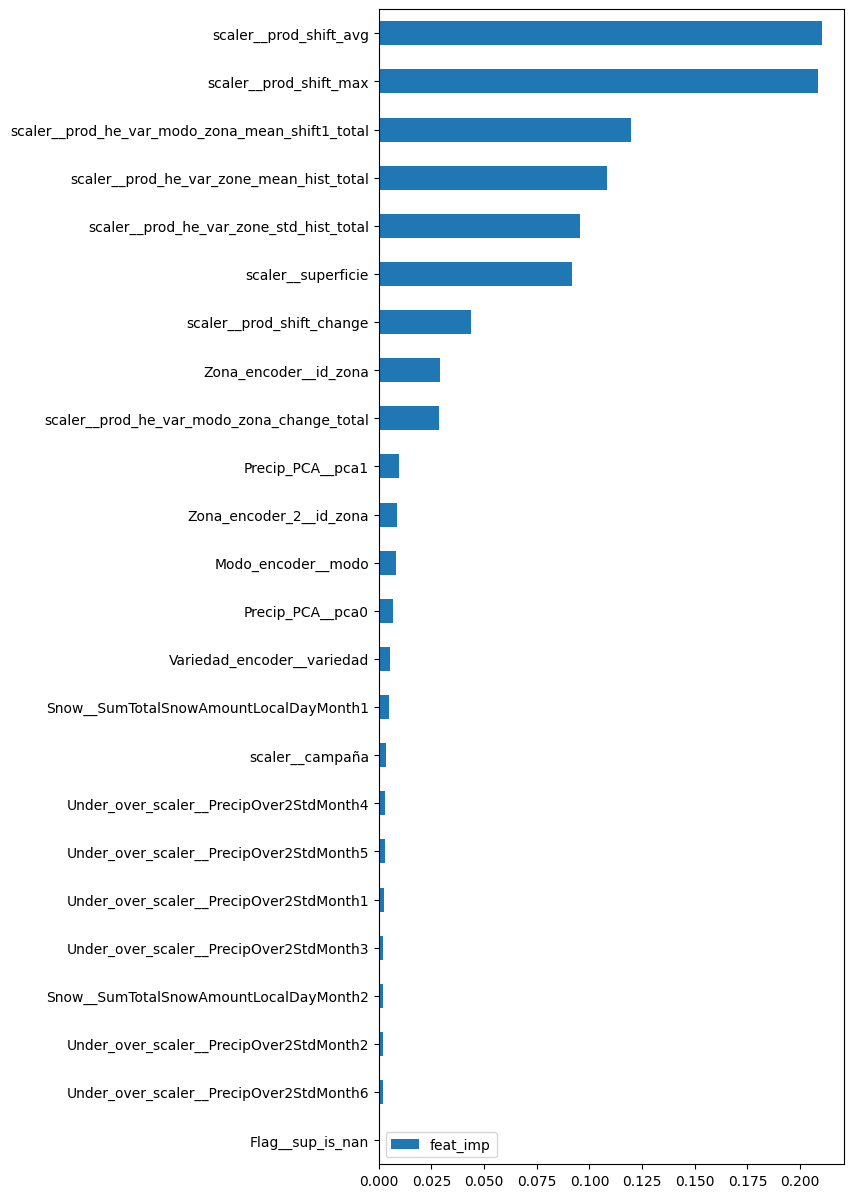

In [45]:
show_feat_imps(
    m[-1].feature_importances_,
    m[:-1].get_feature_names_out(),
)

## Explicabilidad

Para  una  mejor  adopción  de  la  IA  los  modelos  deber  ser  explicables,  debemos 
evitar hablar de modelos de  caja blanca / negra. 

En el desarrollo de  todo modelo 
debe tenerse en cuenta la explicabilidad desde el diseño, un modelo explicable se 
integra en la gestión de  forma más rápida que  uno que  no lo es, incluso modelos 
no  explicables  pueden  llegar  a  no  utilizarse  nunca  aun  teniendo  una  muy  buena 
precisión.

Nuestro mejor modelo fue creado utilizando el algoritmo **Random Forest**. Creemos que este algoritmo tiene una alta capacidad de predicción como tambien de explicabilidad. Nos pareció un buen punto medio entre modelos simples como regresiones lineales y redes neuronales, donde la explicabilidad es menor.

A partir de librerias como **Shap**, podemos visualizar la explicabilidad a partir de gráficos interesantes.

Shap values

In [51]:
import shap
shap.initjs()

In [54]:
explainer = shap.TreeExplainer(m[-1])

In [55]:
x_sample = X.sample(int(0.7*X.shape[0]))
x_sample_trans = pd.DataFrame(
    m[:-1].transform(x_sample),
    columns=m[:-1].get_feature_names_out(),
)

In [56]:
shap_values = explainer.shap_values(x_sample_trans)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


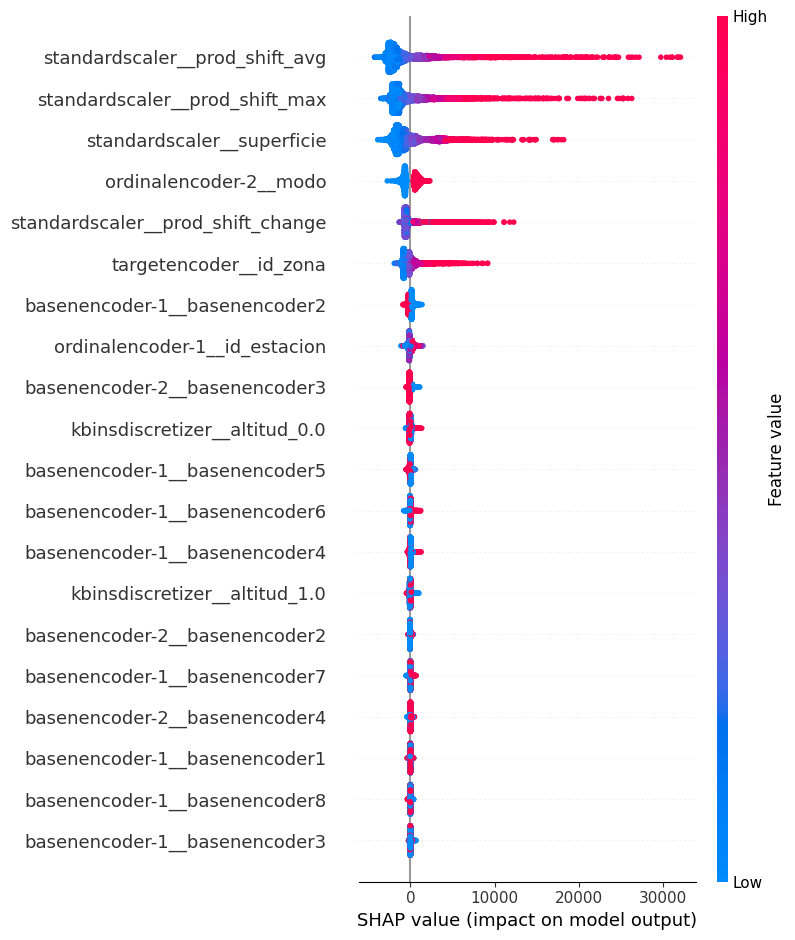

In [57]:
shap.summary_plot(shap_values, x_sample_trans)

# AGRGAR UNOS GRAFICOS MAS YA HECHOS AL FINAL DE EXPLORACION

# 7. Prediccion Final

borrar esto de 10 seeds

In [58]:
# models = []
# for i in range(10):
#     m = mm.get_final_model()
#     m.set_params(randomforestregressor__random_state=mm.seed*(1+i))
#     m.fit(X, y)
#     models.append(m)

# preds_final = []
# for model in models:
#     preds_final.append(model.predict(X_final))
# y_pred_final = np.mean(preds_final,0)

In [59]:
preds_final = data_final[['id_finca', 'variedad','modo','tipo','color','superficie']].copy()
preds_final['produccion'] = y_pred_final
preds_final = preds_final.sort_values(['id_finca', 'variedad','modo','tipo','color','superficie'], ascending=True)

In [60]:
preds_final.to_csv('../data/final/Malbecs.txt', sep="|", header=None)